### Problem Statement

The gaming industry is certainly one of the thriving industries of the modern age and one of those that are most influenced by the advancement in technology. With the availability of technologies like AR/VR in consumer products like gaming consoles and even smartphones, the gaming sector shows great potential. In this hackathon, you as a data scientist must use your analytical skills to predict the sales of video games depending on given factors. Given are 8 distinguishing factors that can influence the sales of a video game. Your objective as a data scientist is to build a machine learning model that can accurately predict the sales in millions of units for a given game.

In [224]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_palette('magma')
sns.set_style('darkgrid')
from datetime import datetime

import scipy.stats as stats
from xgboost import XGBRegressor
import statsmodels.formula.api as sfa
from statsmodels.stats.anova import anova_lm
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor, GradientBoostingRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.ensemble import StackingRegressor
from sklearn.model_selection import KFold, cross_val_score

from warnings import filterwarnings
filterwarnings('ignore')

In [225]:
train_data = pd.read_csv('Train.csv')
test_data = pd.read_csv('Test.csv')

data = pd.concat([train_data,test_data], axis = 0, ignore_index = True)

In [226]:
train_data.shape, test_data.shape, data.shape

((3506, 9), (1503, 8), (5009, 9))

In [227]:
# No misisng values
data.isnull().sum()

ID                    0
CONSOLE               0
YEAR                  0
CATEGORY              0
PUBLISHER             0
RATING                0
CRITICS_POINTS        0
USER_POINTS           0
SalesInMillions    1503
dtype: int64

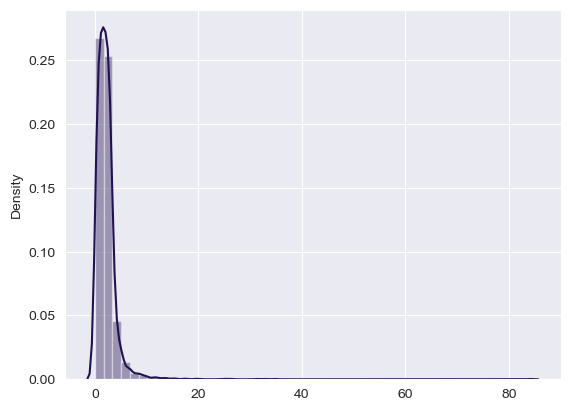

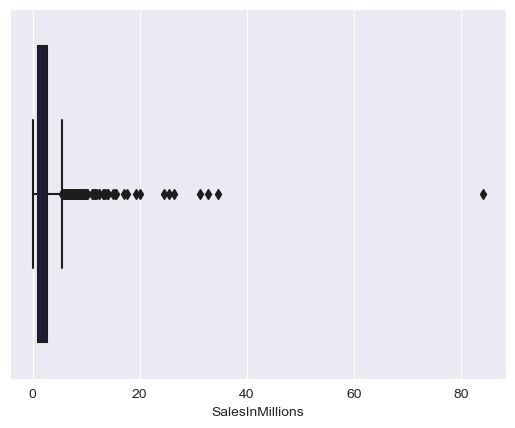

In [228]:
# distribution of target variable
plt.figure(1)
sns.distplot(x = data['SalesInMillions']);

plt.figure(2)
sns.boxplot(x = data['SalesInMillions'])

plt.show()
# 'Sales In Million' is highly skwed data, in upward direction.
# Most of the data lies between 0 to 10, there are some chararcteristics which are bumming sales
# in upward direction

In [229]:
num_cols, cat_cols = list(), list()
for i in data.columns:
    if(str(data[i][2]).isalpha() == True):
        cat_cols.append(i)
    else:
        num_cols.append(i)
        
print(f'Numerical Columns: {num_cols}')
print(f'Categorical Columns: {cat_cols}')

Numerical Columns: ['ID', 'YEAR', 'CRITICS_POINTS', 'USER_POINTS', 'SalesInMillions']
Categorical Columns: ['CONSOLE', 'CATEGORY', 'PUBLISHER', 'RATING']


<Figure size 640x480 with 0 Axes>

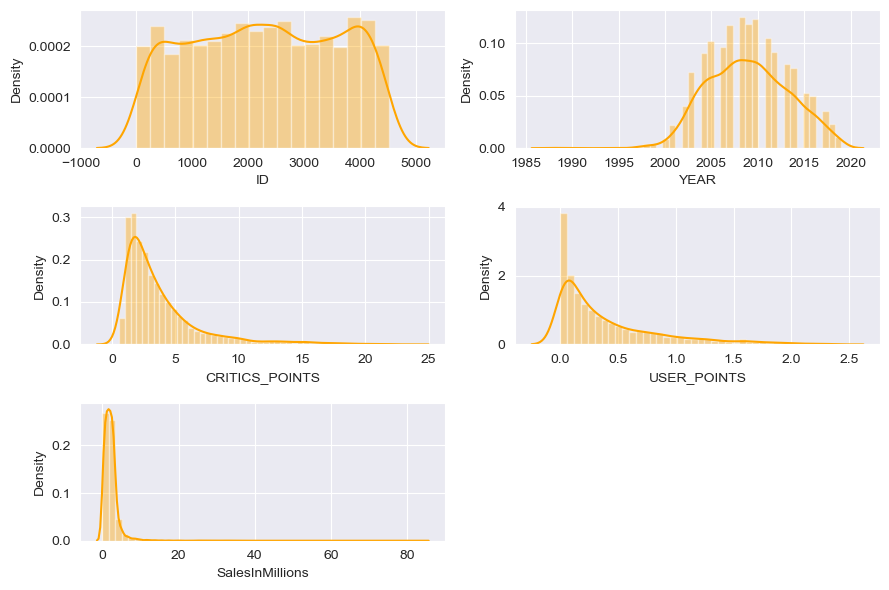

<Figure size 640x480 with 0 Axes>

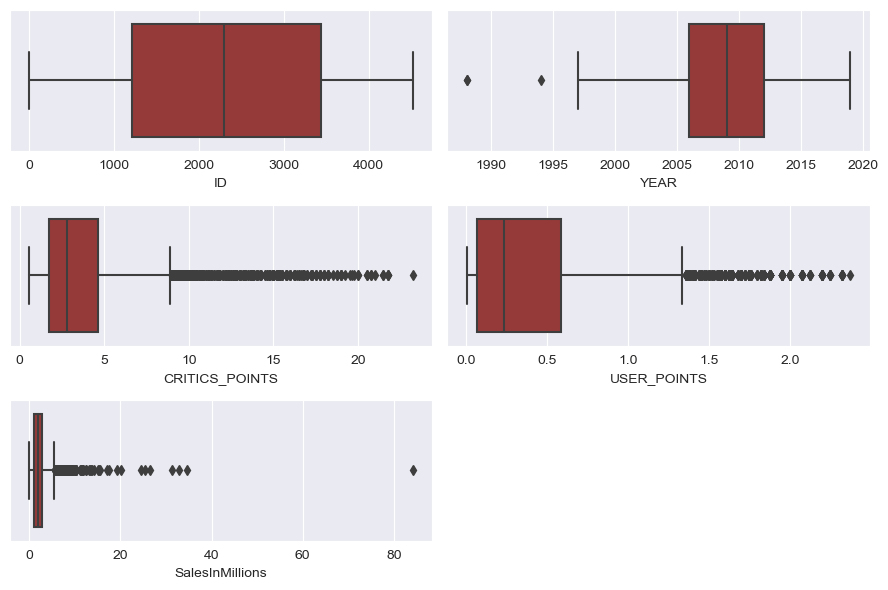

In [230]:
# Univariate Analysis

# Numerical Variables
plt.figure(1)
plt.figure(figsize = (9,6))
j = 1
for i in num_cols:
    plt.subplot(3,2,j)
    sns.distplot(data[i], color = 'orange')
    j += 1
plt.tight_layout()
plt.show()

plt.figure(2)
plt.figure(figsize = (9,6))
j = 1
for i in num_cols:
    plt.subplot(3,2,j)
    sns.boxplot(x = data[i], color = 'brown')
    j += 1
plt.tight_layout()
plt.show()
# identity is unique representation of each game, some ID is repeating in the dataset,
# let's check for duplicate entries. 
# data.duplicated().sum() -- 0 duplicate entries..

# critic-points, user-points are highly skewed in upward direction(+vely skewed)
# There could be a strong correlation between the three variables...
# critic_points, user_points, SalesInMillions

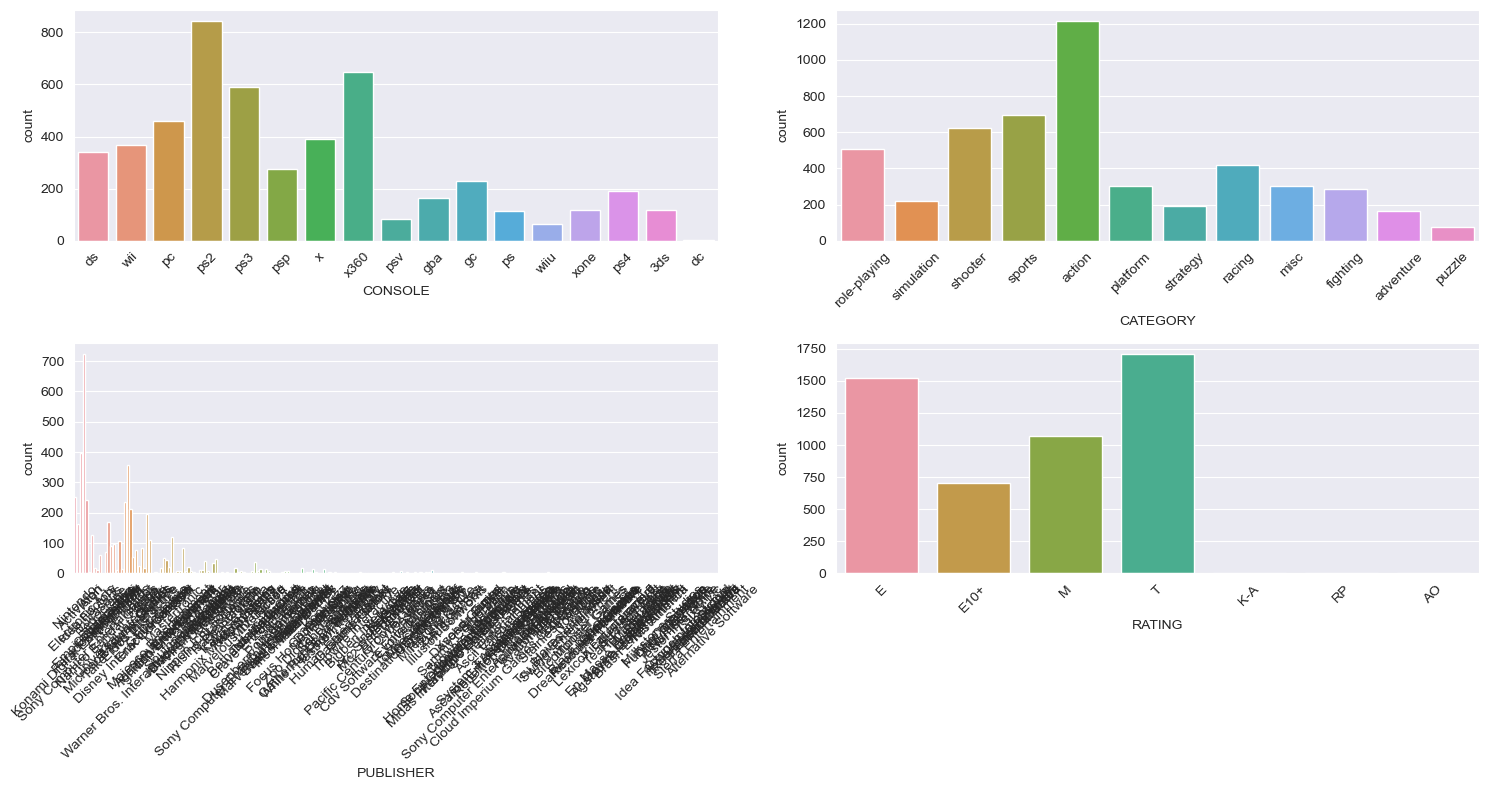

In [231]:
# Categorical Variables
plt.figure(figsize = (15,8))
j = 1
for i in cat_cols:
    plt.subplot(2,2,j)
    sns.countplot(x = data[i])
    plt.xticks(rotation = 45)
    j += 1
plt.tight_layout()
plt.show()
# console -- ps2, ps3, x360, pc, x, others..
# category -- action, sports,shooter
# count of publishers are huge
# ratings -- T, E, M, E10+

In [232]:
# let's start by treating categorical variables
# since all the categorical variables has optimum number of subcategories associated with them.
# data.CONSOLE.value_counts()
def popularity(x):
    if(x in ['ps2','x360','ps3','pc']):
        return 'Very Common'
    elif(x in ['x','wii','ds','psp']):
        return 'Common'
    elif(x in ['gc','ps4','gba']):
        return 'Uncommon'
    else:
        return 'Rare'
data['console_popularity'] = data['CONSOLE'].apply(popularity)

In [233]:
def console_brand(x):
    if(x in ['psp','ps2','ps3','ps4','psv']):
        return 'Sony'
    elif(x in ['x360','xone']):
        return 'Microsoft'
    elif(x in ['x','pc','ps','gc','dc']):
        return 'Others'
    else:
        return 'Nintendo'
data['console_brand'] = data['CONSOLE'].apply(console_brand)

In [234]:
# data.CATEGORY.value_counts()

def game_category(x):
    if(x in ['action','shooter','fighting']):
        return 'Action-Based'
    elif(x == 'role-playing'):
        return x
    elif(x in ['strategy','simulation']):
        return 'Planning Games'
    elif(x in ['sports','racing']):
        return 'Sports'
    else:
        return 'Miscellaneous'

data['game_category'] = data['CATEGORY'].apply(game_category)

In [235]:
# data.PUBLISHER.unique()

In [236]:
# data.RATING.unique()

def rating(x):
    if(x in ['E','E10+','K-A']):
        return 'Everyone'
    elif(x in ['M', 'T','AO',]):
        return 'Adult'
    else:
        return 'Rating Pending'
data['game_zone'] = data['RATING'].apply(rating)

In [237]:
data['Age'] = datetime.now().year - data['YEAR']

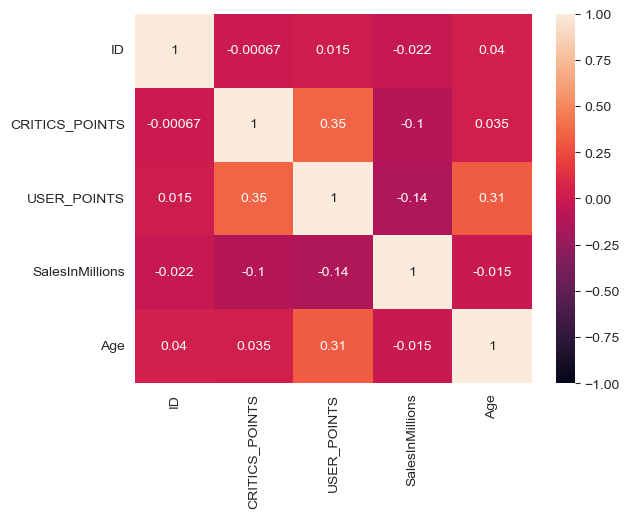

In [238]:
sns.heatmap(data.drop(columns = 'YEAR').corr(), annot = True, vmin = -1, vmax = +1);

# weak positive correlation between critic_points and user_points
# critics_points and user_points are having negative correlation with SalesInMillion, suggesting
# with increase in points there might not be significant increase in sales of game

In [239]:
data['total_points'] = data['CRITICS_POINTS'] + data['USER_POINTS']

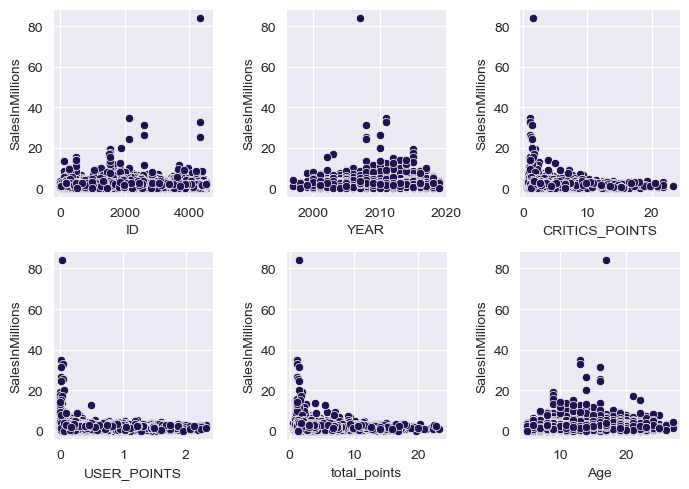

In [240]:
# Bivariate Ananlysis
# Numerical Variable
plt.figure(figsize = (7,5))
num_cols = ['ID','YEAR','CRITICS_POINTS','USER_POINTS','total_points','Age']
j = 1
for i in num_cols:
    plt.subplot(2,3,j)
    sns.scatterplot(x = data[i], y = data['SalesInMillions'])
    j += 1
plt.tight_layout()
plt.show()
# This is clearly suggesting, that increase in points might not result in increase in sales.
# This column might not be significant with target variable, 
# this will be acertain after testing statisticslly

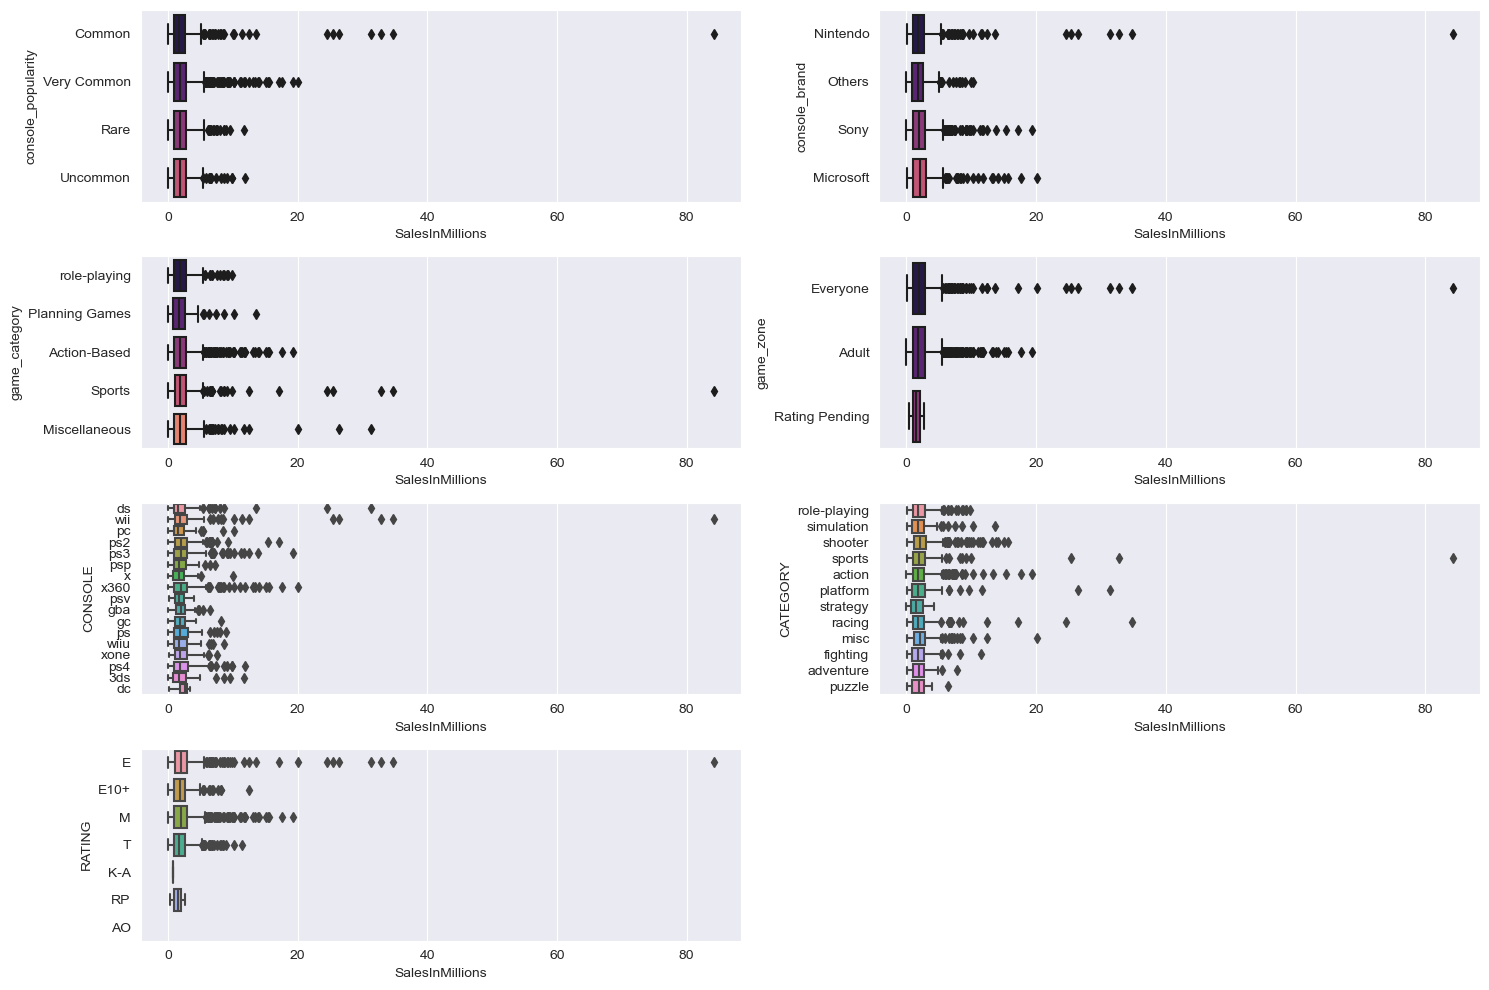

In [241]:
# categorical data
cat_cols = ['console_popularity', 'console_brand', 'game_category', 
            'game_zone','CONSOLE', 'CATEGORY', 'RATING']
plt.figure(figsize = (15,10))
j = 1
for i in cat_cols:
    plt.subplot(4,2,j)
    sns.boxplot(y = data[i], x = data['SalesInMillions'])
    j += 1
plt.tight_layout()
plt.show()

In [242]:
# let's split the data again to test old and newly formed features statistically
 
splitted_data = data.loc[0:train_data.shape[0]-1 ,:]

# Numerical columns
num_cols = ['ID','YEAR','CRITICS_POINTS','USER_POINTS','total_points','SalesInMillions','Age']

for i in num_cols:
    print(f"H0: Data['{i}'] is normal ") # Assuming population to be approximately normally distributed
    print(f"H1: Data['{i}'] is not normal")
    
    test_statistics, pvalue = stats.shapiro(splitted_data[i])
    print(f'P value = {pvalue}')
    
    # concluding
    if(pvalue > 0.05):
        print(f'Fail to Reject Null Hypothesis')
        print()
        print('Performing T-test for independence')
        print()
        print(f"H0: {i} and SalesInMillions are independent to each other") # Assuming population to be approximately normally distributed
        print(f"H1: {i} and SalesInMillions are not independent to each other")
    
        test_statistics, pvalue = stats.ttest_ind(splitted_data[i],splitted_data['SalesInMillions'])
        print(f'P value = {pvalue}')
    
        # concluding
        if(pvalue > 0.05):
            print(f'Fail to Reject Null Hypothesis')
        else:
            print(f'Reject Null Hypothesis')
            print()
        
    else:
        print(f'Reject Null Hypothesis')
        print()
        print('Performing non-parametric test')
        print()
        print(f"H0: {i} and SalesInMillions are independent to each other") # Assuming population to be approximately normally distributed
        print(f"H1: {i} and SalesInMillions are not independent to each other")
    
        test_statistics, pvalue = stats.mannwhitneyu(splitted_data[i],splitted_data['SalesInMillions'])
        print(f'P value = {pvalue}')
    
        # concluding
        if(pvalue > 0.05):
            print(f'Fail to Reject Null Hypothesis')
        else:
            print(f'Reject Null Hypothesis')
    print()
    
# All the numerical vaiables are proven to be significant...
# we will drop critics_points, user_points... intelligence of it has been captured in totalpoints
# As we know, in visualisations... with increase in total_points there might not be necessary
# increase in SalesInMillions.

H0: Data['ID'] is normal 
H1: Data['ID'] is not normal
P value = 9.882734596063698e-31
Reject Null Hypothesis

Performing non-parametric test

H0: ID and SalesInMillions are independent to each other
H1: ID and SalesInMillions are not independent to each other
P value = 0.0
Reject Null Hypothesis

H0: Data['YEAR'] is normal 
H1: Data['YEAR'] is not normal
P value = 8.146087907312017e-18
Reject Null Hypothesis

Performing non-parametric test

H0: YEAR and SalesInMillions are independent to each other
H1: YEAR and SalesInMillions are not independent to each other
P value = 0.0
Reject Null Hypothesis

H0: Data['CRITICS_POINTS'] is normal 
H1: Data['CRITICS_POINTS'] is not normal
P value = 0.0
Reject Null Hypothesis

Performing non-parametric test

H0: CRITICS_POINTS and SalesInMillions are independent to each other
H1: CRITICS_POINTS and SalesInMillions are not independent to each other
P value = 4.2652253724970734e-182
Reject Null Hypothesis

H0: Data['USER_POINTS'] is normal 
H1: Data['

In [243]:
cat_cols = ['console_popularity', 'console_brand', 'game_category', 'game_zone','CONSOLE', 'CATEGORY', 'RATING']
for i in cat_cols:
    print(i)
    print(data[i].value_counts())
    print()
    
    # Excluding 'game_zone','console','rating' from variance analysis.. since samples doesnot have
    # enough number of datapoints.

console_popularity
Very Common    2542
Common         1371
Uncommon        590
Rare            506
Name: console_popularity, dtype: int64

console_brand
Sony         1986
Others       1202
Nintendo     1055
Microsoft     766
Name: console_brand, dtype: int64

game_category
Action-Based      2121
Sports            1113
Miscellaneous      848
role-playing       510
Planning Games     417
Name: game_category, dtype: int64

game_zone
Adult             2783
Everyone          2224
Rating Pending       2
Name: game_zone, dtype: int64

CONSOLE
ps2     843
x360    647
ps3     591
pc      461
x       391
wii     367
ds      339
psp     274
gc      231
ps4     193
gba     166
3ds     119
xone    119
ps      114
psv      85
wiiu     64
dc        5
Name: CONSOLE, dtype: int64

CATEGORY
action          1215
sports           693
shooter          621
role-playing     510
racing           420
platform         305
misc             302
fighting         285
simulation       222
strategy         195
advent

In [244]:
 # Statistical test for categories where there were minimum number of example in samples.
cat_cols = ['console_popularity','console_brand','game_category','CONSOLE']
for a in cat_cols:
    sample = {}
    print(a)
    for i in range(1,splitted_data[a].nunique()+1):
        sample[f'sample{i}'] = list()

    z = 1 # global variable
    for j in splitted_data[a].unique():
        for k in range(splitted_data.shape[0]):
            if(splitted_data.loc[k,a] == j):
                sample[f'sample{z}'].append(splitted_data.loc[k,'SalesInMillions'])
            else:
                pass
        z += 1

    pvalues = []
    for i in range(1,len(sample)+1):
        print(f'Test of Normality','\n\n', 'H0: Data is normal', '\n', 'H1: Data is not normal', 
              '\n')
        test_statistics, pvalue = stats.shapiro(sample[f'sample{i}'])
        print(f'P Value: {pvalue}')
        pvalues.append(pvalue)
        if(pvalue > 0.05):
            print(f'Fail to Reject Null Hypothesis H0:','\n')
        else:
            print(f'Reject Null Hypothesis')
            print()
            
# Since we reject null hypothesis, proving distribution of data is not normal
# let's apply kruskal wallis.

console_popularity
Test of Normality 

 H0: Data is normal 
 H1: Data is not normal 

P Value: 0.0
Reject Null Hypothesis

Test of Normality 

 H0: Data is normal 
 H1: Data is not normal 

P Value: 0.0
Reject Null Hypothesis

Test of Normality 

 H0: Data is normal 
 H1: Data is not normal 

P Value: 3.0586818810592752e-18
Reject Null Hypothesis

Test of Normality 

 H0: Data is normal 
 H1: Data is not normal 

P Value: 3.6759664083786466e-20
Reject Null Hypothesis

console_brand
Test of Normality 

 H0: Data is normal 
 H1: Data is not normal 

P Value: 0.0
Reject Null Hypothesis

Test of Normality 

 H0: Data is normal 
 H1: Data is not normal 

P Value: 1.9114797875406237e-24
Reject Null Hypothesis

Test of Normality 

 H0: Data is normal 
 H1: Data is not normal 

P Value: 9.459358784741389e-39
Reject Null Hypothesis

Test of Normality 

 H0: Data is normal 
 H1: Data is not normal 

P Value: 1.2782892065079103e-29
Reject Null Hypothesis

game_category
Test of Normality 

 H0: Da

In [245]:
cat_cols = ['console_popularity', 'console_brand', 'game_category', 'game_zone','CONSOLE', 'CATEGORY', 'RATING']
for i in cat_cols:
    print('H0: There is no difference amoung group means')
    print('H0: Atleast one sample is showing variance.')
    print()
    print(i,'\n')
    test_statistics, pvalue = stats.kruskal(*(splitted_data.groupby(by = a)['SalesInMillions'].apply(list)))
    print(pvalue)
    # concluding
    if(pvalue > 0.05):
        print('Fail to Reject Null Hypothesis H0:')
    else:
        print('Reject Null Hypothesis H0:')
    print()
    print('-----------------------')
    print()
    # All the categories are showing relation with the target....

H0: There is no difference amoung group means
H0: Atleast one sample is showing variance.

console_popularity 

0.0009353418825518573
Reject Null Hypothesis H0:

-----------------------

H0: There is no difference amoung group means
H0: Atleast one sample is showing variance.

console_brand 

0.0009353418825518573
Reject Null Hypothesis H0:

-----------------------

H0: There is no difference amoung group means
H0: Atleast one sample is showing variance.

game_category 

0.0009353418825518573
Reject Null Hypothesis H0:

-----------------------

H0: There is no difference amoung group means
H0: Atleast one sample is showing variance.

game_zone 

0.0009353418825518573
Reject Null Hypothesis H0:

-----------------------

H0: There is no difference amoung group means
H0: Atleast one sample is showing variance.

CONSOLE 

0.0009353418825518573
Reject Null Hypothesis H0:

-----------------------

H0: There is no difference amoung group means
H0: Atleast one sample is showing variance.

CATE

In [246]:
# for publisher
test_statistics, pvalue = stats.kruskal(*(splitted_data.groupby(by = 'PUBLISHER')['SalesInMillions'].apply(list)))
if(pvalue > 0.05):
    print('Fail to Reject Null Hypothesis H0:')
else:
    print('Reject Null Hypothesis H0:')
    
# Therefore removing 'publisher' from modelling process..

Reject Null Hypothesis H0:


In [247]:
data1 = data.drop(columns = ['console_popularity','console_brand','game_category', 
                             'game_zone','total_points','YEAR'])
data2 = data.drop(columns = ['CONSOLE','YEAR','CATEGORY','PUBLISHER',
                     'CRITICS_POINTS','USER_POINTS','game_zone'])

In [248]:
# Let's do the necessary encoding
data1['CONSOLE'] = data1['CONSOLE'].map(data1.CONSOLE.value_counts(normalize = True).to_dict())

In [249]:
data2 = pd.concat([data2, pd.get_dummies(data2.console_brand, drop_first = True)], axis = 1)
data2.drop(columns = 'console_brand', inplace = True)

In [250]:
data2['console_popularity'] = data2.console_popularity.map(data2.console_popularity.value_counts(normalize = True).to_dict())

In [251]:
# data1
train_data1 = data1.loc[:train_data.shape[0] - 1]

cat_dict = train_data1.groupby(by = 'CATEGORY')['SalesInMillions'].mean().to_dict()
publisher_dict  = train_data1.groupby(by = 'PUBLISHER')['SalesInMillions'].mean().to_dict()
rating_dict = train_data1.groupby(by = 'RATING')['SalesInMillions'].mean().to_dict()

train_data1['CATEGORY'] = train_data1['CATEGORY'].map(cat_dict)
train_data1['PUBLISHER'] = train_data1['PUBLISHER'].map(publisher_dict)
train_data1['RATING'] = train_data1['RATING'].map(rating_dict)

test_data1 = data1.loc[train_data.shape[0] :]

test_data1['CATEGORY'] = test_data1['CATEGORY'].map(cat_dict)
test_data1['PUBLISHER'] = test_data1['PUBLISHER'].map(publisher_dict)
test_data1['RATING'] = test_data1['RATING'].map(rating_dict)

# data2
train_data2 = data2.loc[:train_data.shape[0] - 1]

rating_dict = train_data2.groupby(by = 'RATING')['SalesInMillions'].mean().to_dict()
game_cat_dict = train_data2.groupby(by = 'game_category')['SalesInMillions'].mean().to_dict()

train_data2['RATING'] = train_data2['RATING'].map(rating_dict)
train_data2['game_category'] = train_data2['game_category'].map(game_cat_dict)

test_data2 = data2.loc[train_data.shape[0] :]

test_data2['RATING'] = test_data2['RATING'].map(rating_dict)
test_data2['game_category'] = test_data2['game_category'].map(game_cat_dict)

train_data1.shape, test_data1.shape, train_data2.shape, test_data2.shape

((3506, 9), (1503, 9), (3506, 10), (1503, 10))

In [276]:
# Splitting x and y variables for final model

# data1
x_train1 = train_data1.drop(columns = 'SalesInMillions')
y_train1 = train_data1['SalesInMillions']

x_test1  = test_data1.drop(columns = 'SalesInMillions')

# data2
x_train2 = train_data2.drop(columns = 'SalesInMillions')
y_train2 = train_data2['SalesInMillions']

x_test2 = test_data2.drop(columns = 'SalesInMillions')

lr 2.269450030280738
dtree 2.935857615953567
rbm 2.729156437218642
gbm 2.615241861320816
ada 2.70263251178882
xgb 2.6890499906289804


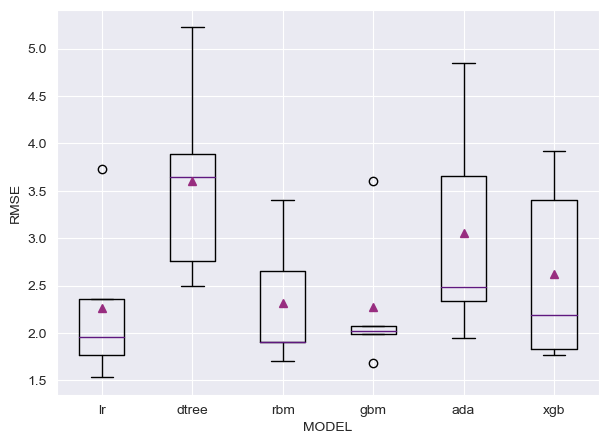

In [253]:
def base_model():
    model = dict()
    model['lr'] = LinearRegression()
    model['dtree'] = DecisionTreeRegressor()
    model['rbm'] = RandomForestRegressor()
    model['gbm'] = GradientBoostingRegressor()
    model['ada'] = AdaBoostRegressor()
    model['xgb'] = XGBRegressor()
    return model
    
# let's evaluate these models 
def evaluation(model):
    kfold = KFold(n_splits = 5, shuffle = True, random_state = 1001)
    scores = abs(cross_val_score(estimator = model, X = x_train1, y = y_train1,
                   scoring = 'neg_root_mean_squared_error', cv = kfold))
    return scores

# let's use the function to calculate scores
models = base_model()
names, results = list(), list()

for name, mymodel in models.items():
    final_score = evaluation(mymodel)
    results.append(final_score)
    names.append(name)
    print(name, np.mean(results))

# Plotting the results
plt.figure(figsize = (7,5))
plt.boxplot(results, labels = names, showmeans = True)
plt.xlabel('MODEL')
plt.ylabel('RMSE')
plt.show()

lr 2.330808920789324
dtree 2.5106004744537147
rbm 2.385256794047883
gbm 2.36464183053458
ada 2.5172502733135276
xgb 2.4691691818102703


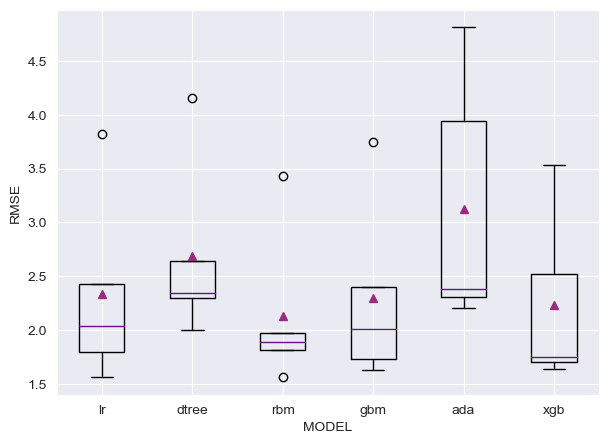

In [254]:
def base_model():
    model = dict()
    model['lr'] = LinearRegression()
    model['dtree'] = DecisionTreeRegressor()
    model['rbm'] = RandomForestRegressor()
    model['gbm'] = GradientBoostingRegressor()
    model['ada'] = AdaBoostRegressor()
    model['xgb'] = XGBRegressor()
    return model
    
# let's evaluate these models 
def evaluation(model):
    kfold = KFold(n_splits = 5, shuffle = True, random_state = 1001)
    scores = abs(cross_val_score(estimator = model, X = x_train2, y = y_train2,
                   scoring = 'neg_root_mean_squared_error', cv = kfold))
    return scores

# let's use the function to calculate scores
models = base_model()
names, results = list(), list()

for name, mymodel in models.items():
    final_score = evaluation(mymodel)
    results.append(final_score)
    names.append(name)
    print(name, np.mean(results))

# Plotting the results
plt.figure(figsize = (7,5))
plt.boxplot(results, labels = names, showmeans = True)
plt.xlabel('MODEL')
plt.ylabel('RMSE')
plt.show()

# These features are able to capture best insights from data, let's build a stacking model based 
# on these results.

In [275]:
lr = LinearRegression()
gbm = GradientBoostingRegressor()
kfold = KFold(n_splits = 5, shuffle = True, random_state = 1001)

model = StackingRegressor(estimators = [('lr',lr),('gbm',gbm)], 
                          final_estimator = RandomForestRegressor(), cv = kfold)
# x_test2['RATING'].fillna(y_train2.mean(), inplace = True)
predictions = model.fit(x_train2, y_train2).predict(x_test2)

In [279]:
submission = pd.DataFrame(predictions, columns = ['SalesInMillions'])
submission.to_csv('Predictions.csv', index = False)
# 1.94383(final RMSE)